# Testing CSRNet ensemble cattle counts on a ground truth test set
We evaluate and visualize predictions from the trained CRSNet ensemble on the ground truth image dataset which has been compared to on the ground cattle numbers (from SI Table 1)

## Evaluation metrics for the model performance

Using the test set we calculate mean standard error, mean standard percentage error and mean error, as well as the error rate (cattle/hectare)

In [11]:
from glob import glob
import torch
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.cm as cm
import torchvision.transforms.functional as F
from src.image import *
from src.model import CSRNet
import json
EPSILON = 1e-7
rcParams['font.size'] = 10

In [50]:
# Define the directories
models_dir = 'parameters/'
testset = 'data/ground_truth/chips'

# List the model parameter files
model_files = [os.path.join(models_dir, file) for file in os.listdir(models_dir)]
# Generate the list of image paths in the test set directory
img_paths = glob(os.path.join(testset, '*.jpg'))


In [51]:
# Initialize arrays to store results
n_models = len(model_files)
n_imgs = len(img_paths)

gt = np.zeros((n_models, n_imgs))
pred = np.zeros((n_models, n_imgs))
mae = np.zeros((n_models, n_imgs))
mape = np.zeros((n_models, n_imgs))

In [52]:
for i, ensembleEntity in enumerate(model_files):
    model = CSRNet()
    model = model.cuda()
    checkpoint = torch.load(ensembleEntity)
    model.load_state_dict(checkpoint['state_dict'])
    
    for j, img_path in enumerate(img_paths):
        img = Image.open(img_path).convert('RGB')
        img_tensor = F.to_tensor(img).cuda().unsqueeze(0)
        
        gt_file = h5py.File(img_path.replace('.jpg', '.h5'), 'r')
        groundtruth = np.asarray(gt_file['density'])
        
        output = model(img_tensor)
        output_sum = output.detach().cpu().sum().numpy()
        
        gt[i, j] = np.round(np.sum(groundtruth))
        pred[i, j] = np.round(output_sum)
        mae[i, j] = abs(gt[i, j] - pred[i, j])
        mape[i, j] = np.round(abs(gt[i, j] - pred[i, j]) / np.maximum(np.sum(groundtruth), 1))
    
    print(f"Model {i+1}:")
    print(f"Sum of predictions: {np.sum(pred[i, :])}")
    print(f"Sum of ground truth: {np.sum(gt[i, :])}")
    print(f"MEAN of ground truth: {np.mean(gt[i, :])}")
    
    print(pred[i, :])
    n_models = n_models +1

/home/leonie/miniconda3/envs/pytorch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/leonie/miniconda3/envs/pytorch-gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model 1:
Sum of predictions: 548.0
Sum of ground truth: 482.0
MEAN of ground truth: 1.4876543209876543
[-0. -0. -0.  1. -0. -0. -0. -0. -0. -0.  1.  1. -0. -0.  0. -0. -0. -0.
  1. -0. -0.  0. -0. -0. -0.  0. -0.  1. -0.  4. -0. -0.  6. -0. -0. -0.
 -0. -0. -0.  1. 24. -0.  1.  1.  0.  4.  2.  8. -0.  0.  1. -0. -0.  1.
 -0. -0. -0. -0. -0. 14.  1. -0. -0. -0. -0. -0. -0. -0.  3. -0.  1.  1.
 -0.  0. -0.  1.  1.  0. -0. -0.  8.  0. -0. -0. -0.  0. -0. -0. -0. -0.
  0. -0.  0.  0.  1. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.
  1. -0. -0. -0. -0. 12. -0. -0. 16. -0.  4. -0. -0. -0. -0. -0. -0. -0.
  1.  1.  0. 42.  3.  2. -0. -0. -0.  2. -0.  3. -0. -0. -0.  0.  0.  0.
 -0. -0.  0. -0. -0. -0.  3. -0. -0.  0.  0. -0. 13. -0.  3. -0. 10. -0.
 -0. -0. -0.  3. -0.  0.  4. -0. -0. 21. -0. -0.  4. 24. -0. -0. -0. -0.
 -0. -0. -0. -0. -0.  3. -0. 10. -0. -0.  0. -0. -0.  3. -0.  1.  0. -0.
 -0.  6. -0. 16.  0.  0.  0.  0. -0. -0. -0. -0. -0. 11. -0. -0.  0.  0.
  1. -0. -0. 15. -0. 

In [53]:
# Calculate mean and standard deviation for the ensemble results
gtt = np.mean(gt, axis=0)
pred_m = np.mean(pred, axis=0)
pred_sd = np.std(pred, axis=0)
mae_m = np.mean(mae, axis=0)
mape_m = np.mean(mape, axis=0)
names = [i.split('/')[2].split('.')[0] for i in img_paths]

In [55]:
# calculate error rate in cattle/hectare
mean_img_size = np.mean([Image.open(img_path).size for img_path in img_paths], axis=0)
mean_img_area_pixels = mean_img_size[0] * mean_img_size[1]
mean_img_area_meters = mean_img_area_pixels * (0.29 ** 2)
mean_img_area_hectares = mean_img_area_meters / 10000
mae_scaled = mae_m / mean_img_area_hectares
print('Error rate in cattle/hectare: ',np.round(np.mean(mae_scaled),2))

Error rate in cattle/hectare:  0.33


In [17]:
# Prepare dictionary with metrics
dictwithmetrics = {
    'img': names,
    'gt': gtt.tolist(),
    'mae': mae_m.tolist(),
    'mape': mape_m.tolist(),
    'predm': pred_m.tolist(),
    'predsd': pred_sd.tolist(),
    'mae_scaled': mae_scaled.tolist()
}

# Specify the output file path
output_file = 'data/test_set_ensemble_metrics.json'

# Write the results to a JSON file
with open(output_file, 'w') as f:
    json.dump(dictwithmetrics, f, indent=4)

## Visualization
We plot four visualizations (as in Figure 1):
 Original Image: The raw input image.
 Ground Truth Density Map: The actual density map representing the true distribution of objects (e.g., cattle) in the image.
 Mean Prediction: The average prediction density map across the ensemble models.
 Standard Deviation of Predictions: The variability in the predictions from the different models.
 Each subplot includes a color bar and textual information about the total counts or standard deviation.


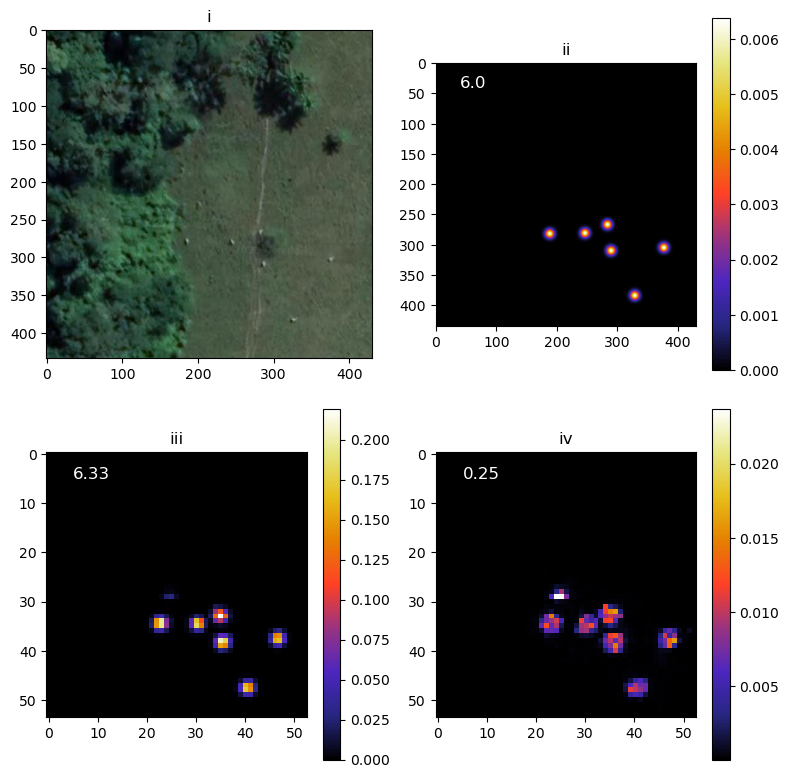

In [18]:
# Define the specific image name
specific_image_name = "22_06_21_3-5_1_4.jpg"

# Find the path of the specific image
name = [path for path in img_paths if specific_image_name in path][0]

im = Image.open(name)
xdim, ydim = im.size
img = F.to_tensor(im.convert('RGB')) 
image = img.cuda()
    
pred = np.zeros((5,ydim//8,xdim//8))
n_models = 0
# Open the ground truth file
gt_file = h5py.File(name.replace('.jpg','.h5'))
groundtruth = np.asarray(gt_file['density'])
gt_file.close() 

for i in model_files:
    model = CSRNet()
    model = model.cuda()
    checkpoint = torch.load(i)
    model.load_state_dict(checkpoint['state_dict'])
    
    # Get model prediction
    output = model(image.unsqueeze(0))
    #gt[n_models,n_imgs] = np.round(np.sum(groundtruth))
    pred[n_models,:,:] = output.squeeze(0).detach().cpu()
    n_models = n_models +1

# Calculate mean and standard deviation of predictions
mean = np.mean(pred, axis=0)
std = np.std(pred, axis=0)
gt = groundtruth

# Plotting
fig = plt.figure(figsize=(8, 8))

# Original Image
plt.subplot(221)
plt.imshow(im)
plt.title('i')

# Ground Truth
plt.subplot(222)
plt.imshow(gt, cmap=cm.CMRmap)
plt.colorbar()
plt.text(40, 40, str(np.round(np.sum(gt), 1)), color='white', fontsize=12)
plt.title('ii')

# Mean Prediction
plt.subplot(223)
plt.imshow(mean, cmap=cm.CMRmap)
plt.colorbar()
plt.text(5, 5, str(np.round(np.sum(mean), 2)), color='white', fontsize=12)
plt.title('iii')

# Standard Deviation of Predictions
plt.subplot(224)
plt.imshow(std, cmap=cm.CMRmap)
plt.colorbar()
plt.text(5, 5, str(np.round(np.std(np.sum(pred, axis=(1, 2))), 2)), color='white', fontsize=12)
plt.title('iv')

plt.tight_layout()
plt.show()